In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pypfopt
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from pypfopt import EfficientFrontier, objective_functions

In [2]:
# btc_NN = pd.read_csv("E:/MSMFT/MF740/data/btc_NN.csv", index_col="Date")
# eth_NN = pd.read_csv("E:/MSMFT/MF740/data/eth_NN.csv", index_col="Date")
# ltc_NN = pd.read_csv("E:/MSMFT/MF740/data/ltc_NN.csv", index_col="Date")
# true = pd.DataFrame(index=btc_NN.index)
# true["BTC"] = btc_NN.y_test
# true["ETH"] = eth_NN.y_test
# true["LTC"] = ltc_NN.y_test
# prices = pd.DataFrame(index=btc_NN.index)
# prices["BTC"] = btc_NN.y_pred
# prices["ETH"] = eth_NN.y_pred
# prices["LTC"] = ltc_NN.y_pred

In [ ]:
btc_gbrt = pd.read_csv("E:/MSMFT/MF740/data/btc_gbrt.csv", index_col="Date")
eth_gbrt = pd.read_csv("E:/MSMFT/MF740/data/eth_gbrt.csv", index_col="Date")
ltc_gbrt = pd.read_csv("E:/MSMFT/MF740/data/ltc_gbrt.csv", index_col="Date")
prices = pd.DataFrame(index=btc_gbrt.index)
prices["btc"] = btc_gbrt.y_pred
prices["eth"] = eth_gbrt.y_pred
prices["ltc"] = ltc_gbrt.y_pred

In [3]:
true = pd.read_csv("E:/MSMFT/MF740/data/test_price.csv",index_col="Date")[:-1]

<AxesSubplot:xlabel='Date'>

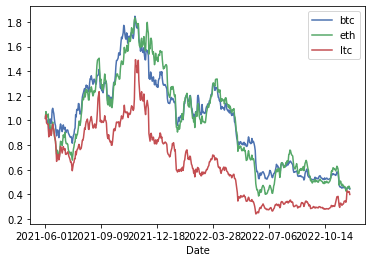

In [116]:
np.cumprod(true.pct_change()+1).plot()

In [7]:
# Expected Return and Covariance Matrix
dr = prices.pct_change()[1:]

In [8]:
def monthly(df1):
    df = df1.copy()
    temp_month = pd.to_datetime(df.index.values).month
    temp_year = pd.to_datetime(df.index.values).year
    df['month'] = temp_month
    df['year'] = temp_year
    return df

# cumulative return
def cum_return(df):
    temp = monthly(df)
    etf_cum = temp.groupby(by=['year','month']).apply(lambda x: np.cumprod(x+1))
    cum = monthly(etf_cum.drop(columns=['year','month']))
    mon_cum = cum.groupby(by=['year','month']).last()
    return mon_cum

In [9]:
cum_ret = cum_return(dr)
cum_ret

btc       eth       ltc
year month                              
2021 6      1.044438  0.920606  0.896858
     7      1.081068  0.991572  1.099852
     8      0.479346  0.643115  0.984514
     9      0.889130  1.099299  0.973592
     10     2.435766  1.479837  1.060793
     11     1.187215  0.990336  1.084724
     12     0.948338  0.971923  1.076956
2022 1      0.877755  1.038110  0.841175
     2      0.878975  1.077530  0.961356
     3      1.028677  1.016628  0.905635
     4      0.905034  0.810223  0.730756
     5      0.973787  1.064404  0.684451
     6      0.997716  0.923113  0.869225
     7      0.994929  0.819746  0.847647
     8      1.032411  1.119402  1.069760
     9      0.987746  0.889090  1.412262
     10     1.009731  0.985316  1.388601
     11     0.809530  1.005076  0.934076

In [10]:
def rebalance(df,func_str):
    ilst = list(cum_ret.index)
    w0 = np.ones(3)
    weights = np.array([])
    df = monthly(df)
    df['month'] = df['month'].apply(lambda x:str(x).zfill(2))
    df['ym'] = df.year.astype('str') + df.month.astype('str')
    for i in range(len(cum_ret)):
        a = ilst[i]
        sa = str(a[0])+str(a[1]).zfill(2)
        temp = df[df.ym<=sa]
        C = temp.iloc[:,[0,1,2]].cov()
        R = cum_ret.loc[a]
        w = func_str(w0,R,C)
        weights = np.append(weights,list(w))
        # w0 = w
    w1 = weights.reshape(len(cum_ret),len(cum_ret.columns))
    weight = pd.DataFrame(w1, index=cum_ret.index, columns=cum_ret.columns)
    return weight

### Equal weight

In [11]:
# 看下面的results感觉没有意义hhh

### Mean-Variance

In [12]:
# Calculate the risk of the portfolio
def portfolio_var(w,C):
    w = np.matrix(w)
    C = np.matrix(C)
    return (w*C*w.T)[0,0]

# Calculate the mean-variance portfolio
def mv_optimal(w0,R,C):
    cons = ({'type':'eq','fun':lambda w:np.sum(w)-1.0},{'type':'ineq','fun':lambda w:w})
    res = minimize(portfolio_var,w0,args=C,method='SLSQP',constraints=cons,options={'disp':False})
    return np.matrix(res.x)

In [13]:
w_mv = rebalance(dr,mv_optimal)

### Max-Sharpe

In [79]:
rf = 0.03
# Calculate the return of the portfolio
def portfolio_return(w,R):
    w = np.matrix(w)
    R = np.matrix(R)
    return ((w.T).dot(R))[0,0]

# Calculate the max Sharpe Ratio using the negative minimum value
def max_sharpe(w,C,R):
    return -(portfolio_return(w,R)-rf/np.sqrt(portfolio_var(w,C)))

# Maximum Sharpe Ratio using formula
def Sharpe_ratio_furmula(w,R,C):
    R = np.matrix(R)
    C = np.matrix(C)
    w = ((np.linalg.inv(C)*R.T-rf)/(np.ones(3)*np.linalg.inv(C)*R.T)).T
    return w

In [80]:
# def max_sp_optimal(w0,R,C):
#     cons = ({'type':'eq','fun':lambda w:np.sum(w)-1.0},{'type':'ineq','fun':lambda w:w})
#     res = minimize(max_sharpe,w0,args=(C,R),method='SLSQP',constraints=cons,options={'disp':False})
#     return np.matrix(res.x)

# rebalance(dr,max_sp_optimal)

In [81]:
w_ms = rebalance(dr,Sharpe_ratio_furmula)

### Risk Parity

In [17]:
# Calculate the risk contribution of each asset
def risk_contribution(w,C):
    sigma = np.sqrt(portfolio_var(w,C))
    mrc = C*w.T/sigma  # marginal risk contribution
    rc = np.multiply(mrc,w.T)  # risk contribution
    return rc
    
# Calculate portfolio risk
def portfolio_risk(w,C,expected_w):
    w = np.matrix(w)
    C = np.matrix(C)
    expected_w = np.matrix(expected_w)
    sigma = np.sqrt(portfolio_var(w,C))
    expected_risk = np.asmatrix(np.multiply(sigma,expected_w))
    RC = risk_contribution(w,C)
    return sum(np.square(RC-expected_risk.T))[0,0]

# Calculate the weight of each asset according to its expected risk contribution
def rp_optimal(w0,expected_w,C):
    cons = ({'type':'eq','fun':lambda expected_w:np.sum(expected_w)-1.0},{'type':'ineq','fun':lambda expected_w:expected_w})
    res = minimize(portfolio_risk,w0,args=(C,expected_w),method='SLSQP',constraints=cons,options={'disp':False})
    #res = minimize(portfolio_risk,w0,args=(C,expected_w), method='nelder-mead',constraints=cons,options={'xatol': 1e-8,'disp': True})
    return np.matrix(res.x)

In [18]:
w_rp = rebalance(dr,rp_optimal)

### Black Litterman

In [31]:
mkt_cap = {"btc": 881565,"eth": 29940,"ltc": 22653}

In [20]:
def rac(df):
    return black_litterman.market_implied_risk_aversion(df.iloc[:,[0]])

df1 = pd.DataFrame(prices)
df1 = monthly(df1)
deltas = np.abs(df1.groupby(by=['year','month']).apply(rac))
#deltas = deltas.shift(1)[1:]

In [21]:
def blm(w0,S,delta,diff):
    viewdict = {"btc": diff[0],"eth": diff[1],"ltc": diff[2]}
    market_prior = black_litterman.market_implied_prior_returns(w0, delta, S)
    bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict,tau=1/3)
    # confidences = [0.5,0.5,0.5]
    # bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)
    ret_bl = bl.bl_returns()
    S_bl = bl.bl_cov()
    ef = EfficientFrontier(ret_bl, S_bl)
    ef.add_objective(objective_functions.L2_reg)
    ef.max_sharpe()
    weights = ef.clean_weights()
    # w = list(weights.values())
    return weights

In [57]:
def rebalance_bl(df):
    ilst = list(cum_ret.index)
    w0 = mkt_cap
    weights = np.array([])
    df = monthly(df)
    df['month'] = df['month'].apply(lambda x:str(x).zfill(2))
    df['ym']=df.year.astype('str')+df.month.astype('str')
    for i in range(len(cum_ret)):
        a = ilst[i]
        sa = str(a[0])+str(a[1]).zfill(2)
        temp = df[df.ym<=sa]
        #print(temp)
        #S = (risk_models.CovarianceShrinkage(temp.iloc[:,[0,1,2]]).ledoit_wolf())
        S = temp.iloc[:,[0,1,2]].cov()
        delta = (deltas.loc[a])[0]
        diff = cum_ret.loc[a]
        w = blm(w0,S,delta,diff)
        weights = np.append(weights,list(w.values()))
        w0 = w
    w1 = weights.reshape(len(cum_ret),len(cum_ret.columns))
    weight = pd.DataFrame(w1,index=cum_ret.index,columns=cum_ret.columns)
    return weight

In [58]:
w_bl = rebalance_bl(dr)

E:\program\Anaconda\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:257: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


### Portfolio Evaluation

In [108]:
true_cum = cum_return(true.pct_change()[1:])

In [109]:
def evaluation(ret,weight):
    cum = np.sum(weight*ret,1)
    return np.cumprod(cum)

<AxesSubplot:xlabel='year,month'>

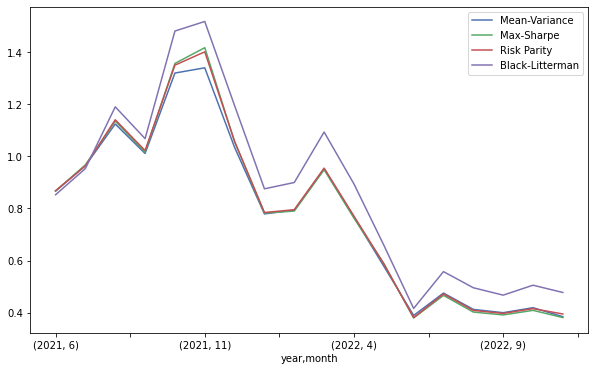

In [110]:
exp_return = pd.DataFrame(index=true_cum.index)
# exp_return["Equal Weights"] = np.cumprod(np.mean(true_cum,1))
exp_return["Mean-Variance"] = np.cumprod(np.sum(w_mv*true_cum,1))
exp_return["Max-Sharpe"] = np.cumprod(np.sum(w_ms*true_cum,1))
exp_return["Risk Parity"] = evaluation(true_cum,w_rp)
exp_return["Black-Litterman"] = evaluation(true_cum,w_bl)
exp_return.plot(figsize = (10,6))

In [112]:
def port_sp(w,cum):
    cum = np.cumprod(cum)
    return np.mean(w*cum,1)/np.std(w*cum,1)

<AxesSubplot:xlabel='year,month'>

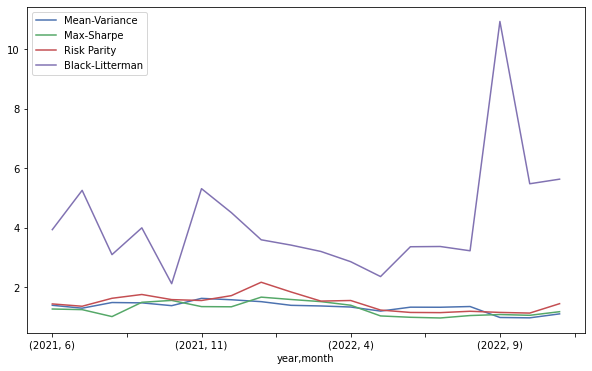

In [115]:
sharpe = pd.DataFrame(index=true_cum.index)
# sharpe["Equal Weights"] = port_sp([1/3,1/3,1/3],true_cum)
sharpe["Mean-Variance"] = port_sp(w_mv,true_cum)
sharpe["Max-Sharpe"] = port_sp(w_ms,true_cum)
sharpe["Risk Parity"] = port_sp(w_rp,true_cum)
sharpe["Black-Litterman"] = port_sp(w_bl,true_cum)
sharpe.plot(figsize = (10,6))